In [ ]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from global_land_mask import globe
#from functions.grid import get_bounds_rectilinear


datadir = "../data/"

In [14]:
ds = xr.open_mfdataset(datadir + "originaldata/" + "DTU15MDT_2min.mdt.nc")
ds

<xarray.Dataset> Size: 467MB
Dimensions:  (lon: 10801, lat: 5400)
Coordinates:
  * lon      (lon) float64 86kB 0.0 0.03333 0.06667 0.1 ... 359.9 360.0 360.0
  * lat      (lat) float64 43kB -89.98 -89.95 -89.92 ... 89.92 89.95 89.98
Data variables:
    mdt      (lat, lon) float64 467MB dask.array<chunksize=(5400, 10801), meta=np.ndarray>
Attributes:
    Conventions:  COARDS/CF-1.0
    title:        DTU15MDT_2min.mdt.nc
    source:       Danish National Space Center
    node_offset:  1

In [15]:
ds = ds.sel(lat=slice(60, 90))
ds

<xarray.Dataset> Size: 78MB
Dimensions:  (lon: 10801, lat: 900)
Coordinates:
  * lon      (lon) float64 86kB 0.0 0.03333 0.06667 0.1 ... 359.9 360.0 360.0
  * lat      (lat) float64 7kB 60.02 60.05 60.08 60.12 ... 89.92 89.95 89.98
Data variables:
    mdt      (lat, lon) float64 78MB dask.array<chunksize=(900, 10801), meta=np.ndarray>
Attributes:
    Conventions:  COARDS/CF-1.0
    title:        DTU15MDT_2min.mdt.nc
    source:       Danish National Space Center
    node_offset:  1

In [16]:
new_lon = ((ds.lon + 180) % 360) - 180

# Step 2: Explicitly handle edge cases to remove duplicates
# Replace -180 with 180 temporarily to avoid overlap
new_lon = xr.where(new_lon == -180, 180, new_lon)

# Step 3: Deduplicate lon coordinates by finding unique values
_, unique_idx = np.unique(new_lon, return_index=True)
new_lon_unique = new_lon.isel(lon=unique_idx)

# Step 4: Assign the deduplicated lon to the dataset
ds = ds.isel(lon=unique_idx).assign_coords(lon=new_lon_unique)

# Step 5: Sort the dataset by lon
ds = ds.sortby('lon')

In [17]:
for lon in ds.lon:
    if lon == 0:
        print("OH NO")

OH NO


In [6]:
ds.coords["lon"] = (ds.coords["lon"] + 180) % 360 - 180
ds = ds.sortby(ds.lon)
ds
#print(len(ds.lon.values))
#print(len(set(ds.lon.values)))

<xarray.Dataset> Size: 78MB
Dimensions:  (lat: 900, lon: 10801)
Coordinates:
  * lat      (lat) float64 7kB 60.02 60.05 60.08 60.12 ... 89.92 89.95 89.98
  * lon      (lon) float64 86kB -180.0 -180.0 -179.9 ... 179.9 179.9 180.0
Data variables:
    mdt      (lat, lon) float64 78MB dask.array<chunksize=(900, 10801), meta=np.ndarray>
Attributes:
    Conventions:  COARDS/CF-1.0
    title:        DTU15MDT_2min.mdt.nc
    source:       Danish National Space Center
    node_offset:  1

In [18]:
lon, lat = np.meshgrid(ds.lon, ds.lat)
is_in_ocean = globe.is_ocean(lat, lon)
is_in_ocean

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

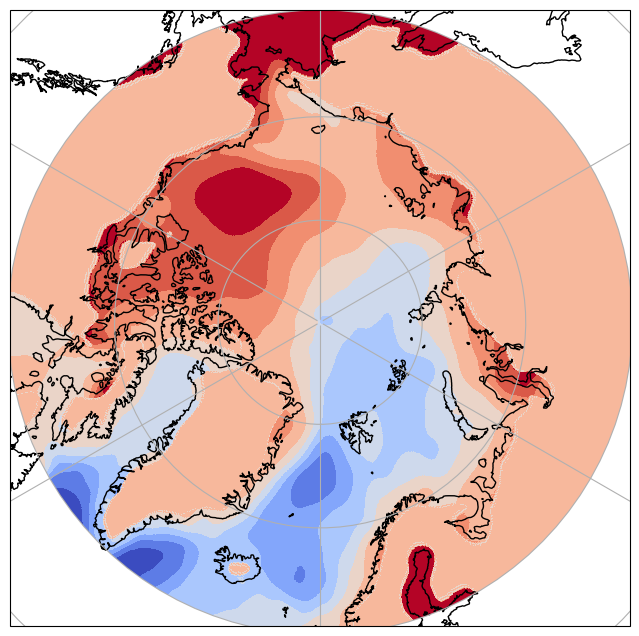

In [ ]:
fig, ax = plt.subplots(1, 1,
                       figsize=(10, 8),
                       subplot_kw={"projection" : ccrs.NorthPolarStereo()}
                      )
ax.coastlines()
ax.gridlines()
#ax.add_feature(cfeature.LAND, color="grey", zorder=100)
ax.set_extent([-180,180,60,90], crs=ccrs.PlateCarree())


cmap = plt.get_cmap('coolwarm', 10)

c = ax.pcolormesh(ds.lon, ds.lat, ds.mdt.isel(lon=slice(0, -1), lat=slice(0, -1)), 
                  shading='flat',
                  transform=ccrs.PlateCarree(),
                  vmin=-0.60, 
                  vmax=0.40,
                  cmap=cmap,
                  rasterized=True
           )



In [19]:
ds = ds.where(is_in_ocean)
ds

<xarray.Dataset> Size: 78MB
Dimensions:  (lat: 900, lon: 10800)
Coordinates:
  * lat      (lat) float64 7kB 60.02 60.05 60.08 60.12 ... 89.92 89.95 89.98
  * lon      (lon) float64 86kB -180.0 -179.9 -179.9 ... 179.9 180.0 180.0
Data variables:
    mdt      (lat, lon) float64 78MB dask.array<chunksize=(900, 10800), meta=np.ndarray>
Attributes:
    Conventions:  COARDS/CF-1.0
    title:        DTU15MDT_2min.mdt.nc
    source:       Danish National Space Center
    node_offset:  1

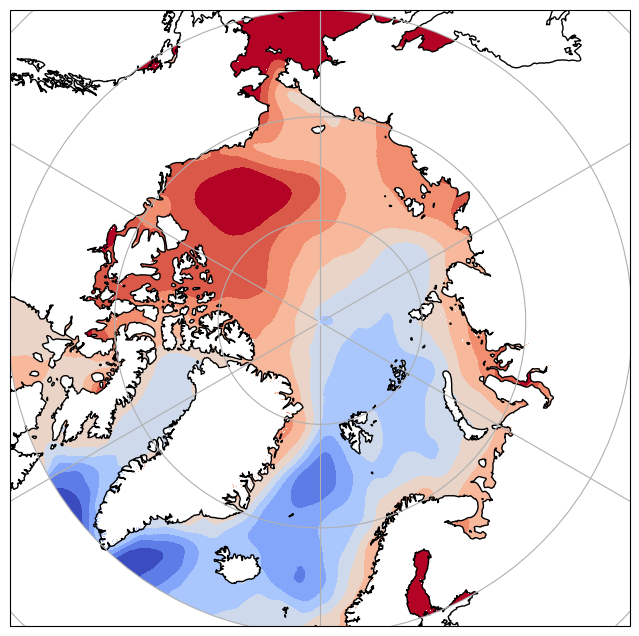

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig, ax = plt.subplots(1, 1,
                       figsize=(10, 8),
                       subplot_kw={"projection" : ccrs.NorthPolarStereo()}
                      )
ax.coastlines()
ax.gridlines()
#ax.add_feature(cfeature.LAND, color="grey", zorder=100)
ax.set_extent([-180,180,60,90], crs=ccrs.PlateCarree())


cmap = plt.get_cmap('coolwarm', 10)

c = ax.pcolormesh(ds.lon, ds.lat, ds.mdt.isel(lon=slice(0, -1), lat=slice(0, -1)), 
                  shading='flat',
                  transform=ccrs.PlateCarree(),
                  vmin=-0.60, 
                  vmax=0.40,
                  cmap=cmap,
                  rasterized=True
           )


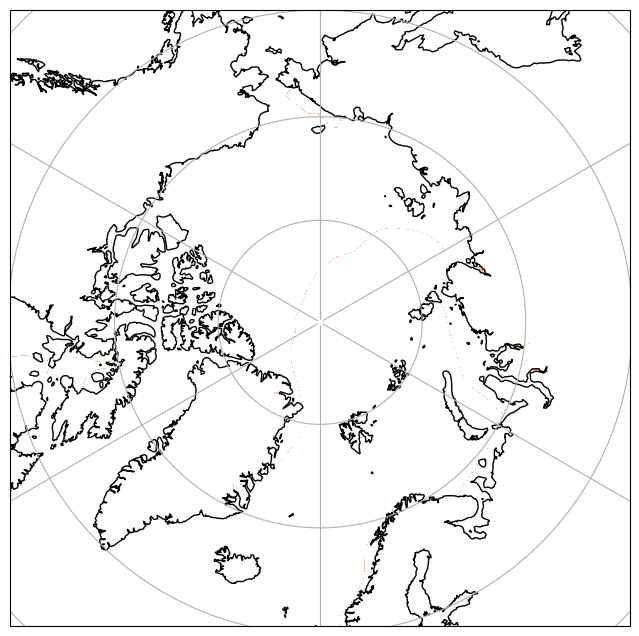

In [ ]:
fig, ax = plt.subplots(1, 1,
                       figsize=(10, 8),
                       subplot_kw={"projection" : ccrs.NorthPolarStereo()}
                      )
ax.coastlines()
ax.gridlines()
#ax.add_feature(cfeature.LAND, color="grey", zorder=100)
ax.set_extent([-180,180,60,90], crs=ccrs.PlateCarree())


cmap = plt.get_cmap('coolwarm', 10)

c = ax.pcolormesh(ds.lon, ds.lat, ds.mdt.where(ds.mdt == 0).isel(lon=slice(0, -1), lat=slice(0, -1)), 
                  shading='flat',
                  transform=ccrs.PlateCarree(),
                  vmin=-0.60, 
                  vmax=0.40,
                  cmap=cmap,
                  rasterized=True
           )



In [ ]:
ds.to_netcdf(datadir + "mean_dynamic_topography_dtu.nc")